# Diameter

In [1]:
import json
import os

from cycler import cycler
from pathlib import Path
from pprint import pprint

import arviz as az
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from matplotlib import pyplot as plt
from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive, save_figure

INFERENCES_DIR = Path("..") / "inferences"
DATA_DIR = Path("..") / "data"
PLOTS_DIR = Path("..") / "plots"
CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)

In [2]:
raw = pd.read_csv(DATA_DIR / "raw" / "data_sphincter_paper.csv")
prepared = load_prepared_data(DATA_DIR / "prepared" / "pulsatility.json")
msts = prepared.measurements
msts

,age,mouse,vessel_type,treatment,pd1,pd2,pd3,pd_sum,pd_ratio,pc1,pc2,pc3,pc_sum,pc_ratio,pressure_d,pressure_norm,diameter,diameter_norm,speed
951,adult,100920,bulb,baseline,2092.769661,230.101368,NaN,2322.871030,0.099059,429.023989,62.665046,NaN,491.689035,0.127449,53.897095,-10.928549,7.602068,-1.584940,NaN
952,adult,100920,cap1,baseline,248.834511,22.605898,4.536618,275.977028,0.081912,110.760211,26.535705,7.343648,144.639565,0.183461,52.141367,-12.684277,5.478392,-1.470458,NaN
953,adult,100920,cap2,baseline,91.102217,17.483219,NaN,108.585437,0.161009,799.006296,86.906644,NaN,885.912939,0.098098,52.015743,-12.809901,3.422574,-2.909203,NaN
954,adult,100920,cap3,baseline,71.696774,13.260128,NaN,84.956902,0.156081,333.158678,53.719684,NaN,386.878362,0.138854,53.169234,-11.656410,3.593345,-2.330455,NaN
949,adult,100920,pen_art,baseline,713.220873,32.719247,NaN,745.940119,0.043863,60.922862,3.217208,NaN,64.140070,0.050159,52.937415,-11.888229,11.229894,-3.101070,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,old,70921,cap4,after_ablation,349.130122,34.586358,5.652198,389.368678,0.088827,210.788359,28.466366,3.230240,242.484965,0.117394,41.341911,-20.039797,6.876791,1.377800,1.879609
1479,old,70921,cap4,after_hyper,148.901628,14.440734,NaN,163.342362,0.088408,56.990737,5.981480,NaN,62.972217,0.094986,45.762510,-15.619199,5.912477,0.413486,1.918037
1467,old,70921,cap4,baseline,89.617245,9.774013,0.522649,99.913907,0.097824,75.143608,11.950067,0.452126,87.545801,0.136501,48.828848,-12.552860,5.658166,0.159174,1.440864
1461,old,70921,pen_art,baseline,1774.598017,299.930384,71.410804,2145.939204,0.139766,593.486878,54.247116,12.599400,660.333395,0.082151,48.380029,-13.001680,14.824925,0.493960,NaN


<Axes: xlabel='vessel_type', ylabel='diameter'>

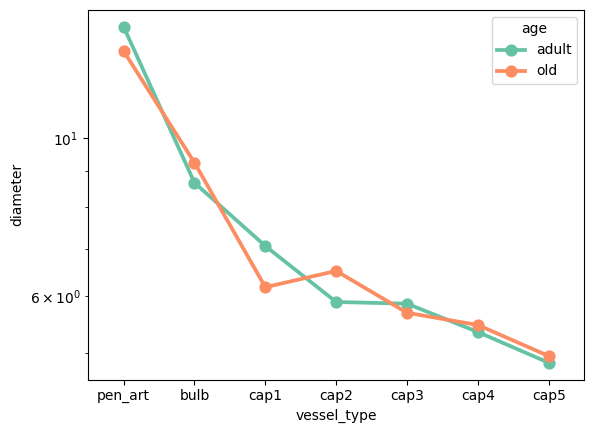

In [3]:
sns.pointplot(msts, x="vessel_type", y="diameter", hue="age", log_scale=True, errorbar=None)

In [4]:
idata = az.InferenceData.from_zarr(os.path.join(INFERENCES_DIR, "diameter", "idata"))
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [5]:
az.summary(idata, var_names="mu", filter_vars="regex")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[adult],1.970,0.156,1.684,2.279,0.004,0.003,1441.0,2127.0,1.0
mu[old],1.955,0.156,1.656,2.250,0.004,0.003,1415.0,2036.0,1.0


In [6]:
az.summary(idata, var_names="sigma")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.238,0.007,0.225,0.251,0.0,0.0,7365.0,2749.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

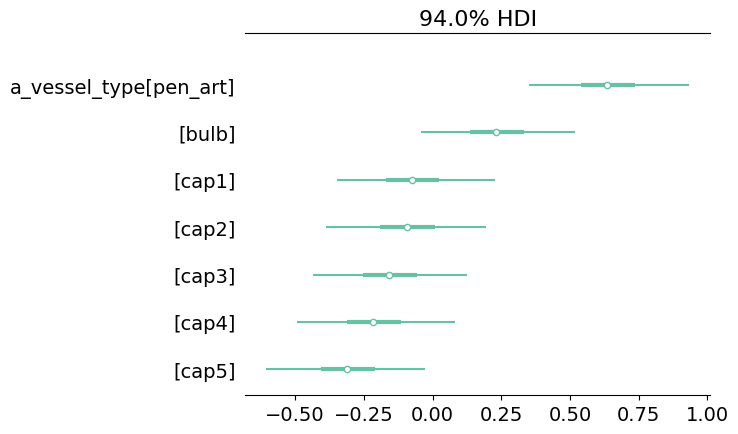

In [7]:
az.plot_forest(idata.posterior["a_vessel_type"], combined=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

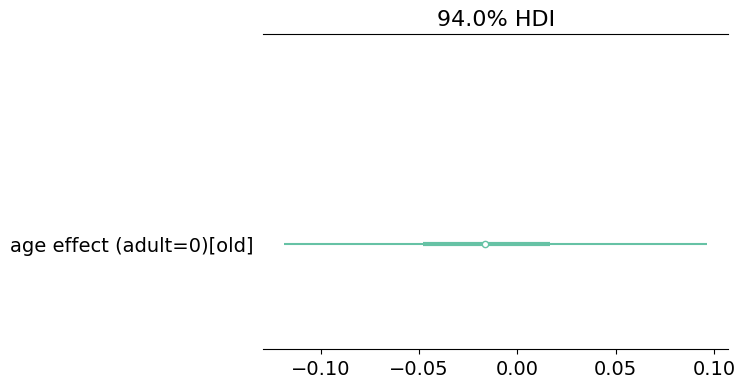

In [8]:
t = (
    idata.posterior["mu"] - idata.posterior["mu"].sel(age="adult")
).rename("age effect (adult=0)")


az.plot_forest(t, combined=True, coords={"age": ["old"]})

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

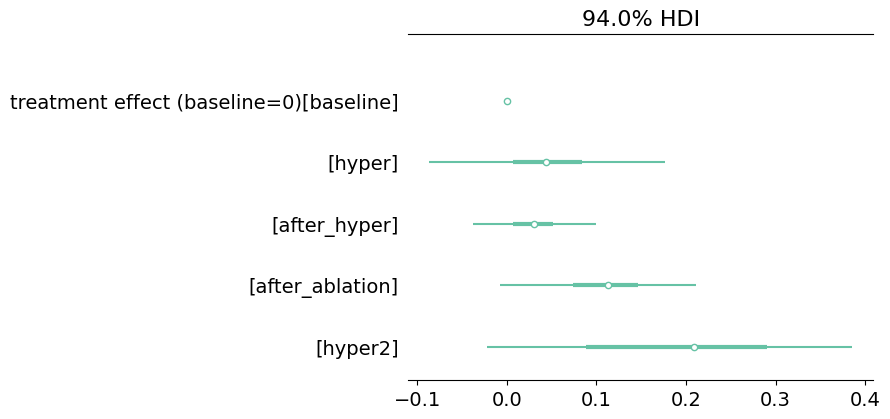

In [9]:
t = (
    idata.posterior["a_treatment"]
    - idata.posterior["a_treatment"].sel(treatment="baseline")
).rename("treatment effect (baseline=0)")

az.plot_forest(t, combined=True)

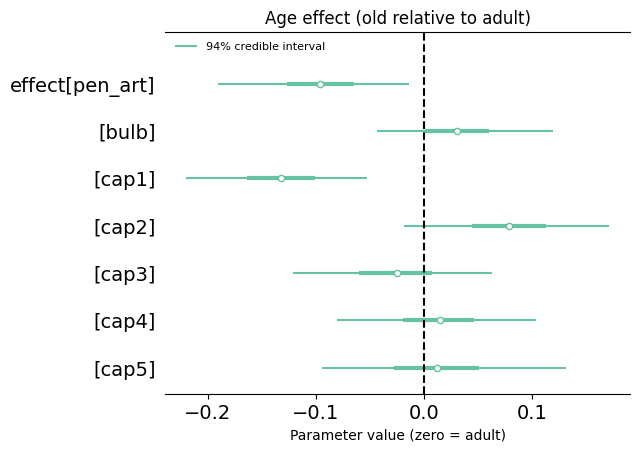

In [10]:
t = (
    idata.posterior["mu"] - idata.posterior["mu"].sel(age="adult")
    + (idata.posterior["a_age_vessel_type"] - idata.posterior["a_age_vessel_type"].sel(age="adult"))
).transpose(*["chain", "draw", "vessel_type", "age"]).rename("effect")

az.plot_forest(
    t, 
    combined=True,
    coords={"age": "old"},
    legend=True
    
)
f = plt.gcf()
ax = plt.gca()
ax.axvline(0, linestyle="--", color="black")
ax.legend([ax.collections[0]], ["94% credible interval"], frameon=False, loc="upper left", fontsize=8)
ax.set(title="Age effect (old relative to adult)", xlabel="Parameter value (zero = adult)");

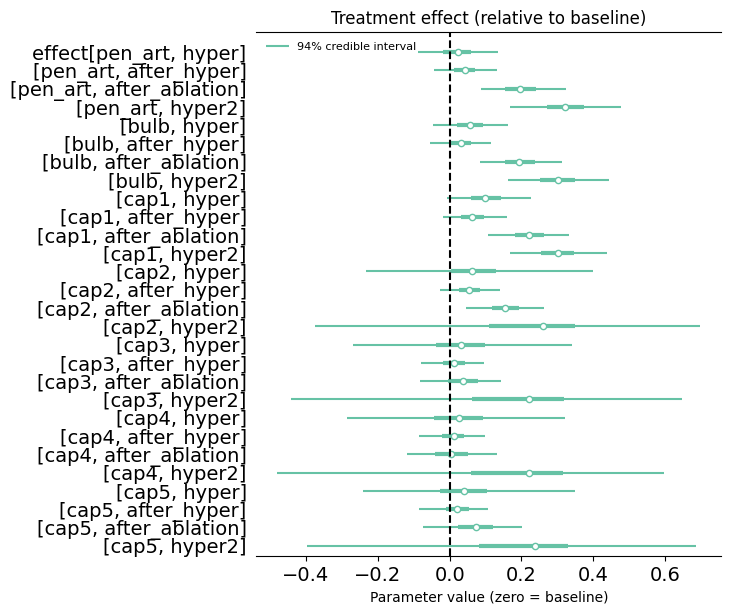

In [11]:
t = (
    (idata.posterior["a_treatment"] - idata.posterior["a_treatment"].sel(treatment="baseline"))
    + (idata.posterior["a_vessel_type_treatment"] - idata.posterior["a_vessel_type_treatment"].sel(treatment="baseline"))
).transpose(*["chain", "draw", "vessel_type", "treatment"]).rename("effect")

az.plot_forest(
    t, 
    combined=True,
    coords={"treatment": ["hyper", "after_hyper", "after_ablation", "hyper2"]},
    legend=True
    
)
f = plt.gcf()
ax = plt.gca()
ax.axvline(0, linestyle="--", color="black")
ax.legend([ax.collections[0]], ["94% credible interval"], frameon=False, loc="upper left", fontsize=8)
ax.set(title="Treatment effect (relative to baseline)", xlabel="Parameter value (zero = baseline)");

[]

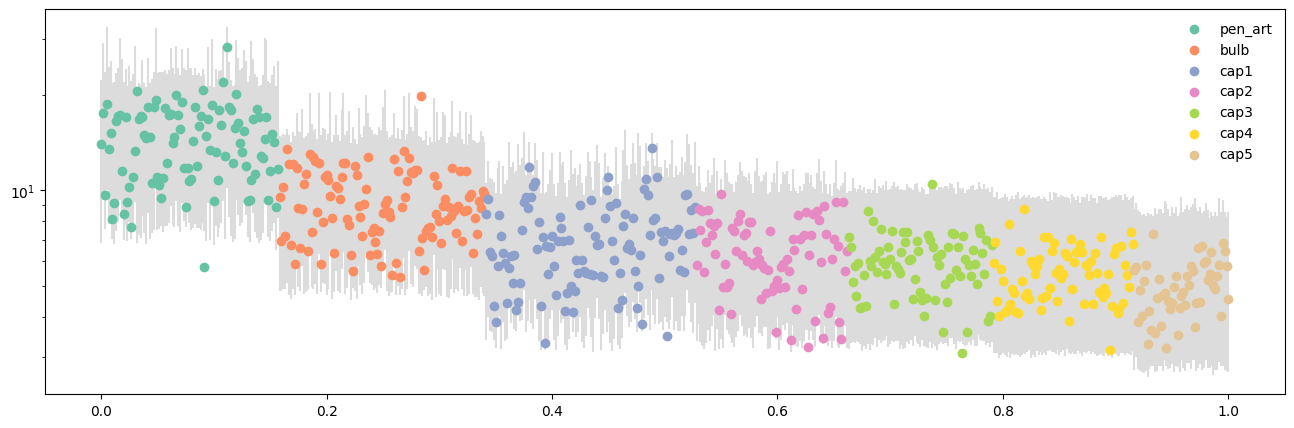

In [12]:
yrep = idata.posterior_predictive["yrep"]

f, ax = plt.subplots(1, 1, figsize=[16, 5])

plot_obs(ax, msts["diameter"], cat=msts["vessel_type"]);
plot_predictive(ax, yrep, zorder=-1, cat=msts["vessel_type"])
ax.legend(frameon=False)
ax.semilogy()

[]

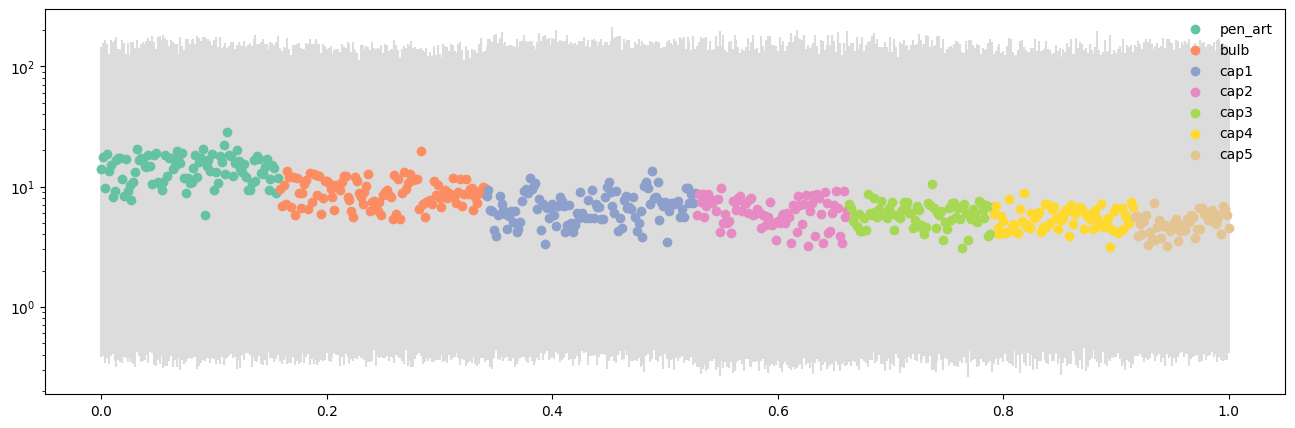

In [14]:
yrep = idata.prior_predictive["yrep"]

f, ax = plt.subplots(1, 1, figsize=[16, 5])

plot_obs(ax, msts["diameter"], cat=msts["vessel_type"]);
plot_predictive(ax, yrep, zorder=-1, cat=msts["vessel_type"])
ax.legend(frameon=False)
ax.semilogy()